In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from _data.data_utils import read_in
from _fitting.fitting_utils import hist_plot, CI_plot, CI_plot_alt, CI_plot_both, plot_posteriors_side_by_side, plot_spline
import pymc as pm
import arviz as az
from patsy import dmatrix
import nutpie
import time
from pprint import pprint
from IPython.display import display
import seaborn as sns
from pymc.variational.callbacks import CheckParametersConvergence

az.style.use("arviz-darkgrid")


if '___laptop' in os.listdir('../'):
    # laptop folder
    folder = "../../_data/p-dengue/"
elif '___server' in os.listdir('../'):
    # server folder
    folder = "../../../../../data/lucaratzinger_data/p_dengue/"

In [2]:
data = read_in(folder, admin=2, max_lag=6, dropna=True, end_year=2019, end_month=12)
# data = data.dropna()
# data = data.loc[data['year']<2020, :]

rng = np.random.default_rng(42)
keep_admin2 = rng.choice(
    data["admin2"].unique(),
    size=int(0.5 * data["admin2"].nunique()),
    replace=False
)
#data = data[data["admin2"].isin(keep_admin2)]

In [3]:
data.columns

Index(['admin1', 'admin2', 'year', 'month', 'cases', 'ONI',
       't2m_mean_unweighted (0)', 't2m_mean_pop_weighted (0)',
       't2m_min_unweighted (0)', 't2m_min_pop_weighted (0)',
       ...
       'surveillance_pop_weighted', 'urban_surveillance_nonweighted',
       'urban_surveillance_pop_weighted', 'density_unweighted',
       'density_pop_weighted', 'urban_density_unweighted',
       'urban_density_pop_weighted', 'urbanisation_nonweighted_std',
       'urbanisation_pop_weighted_std', 'ONI_std'],
      dtype='object', length=160)

In [4]:
data

admin1         admin2  year  month  cases   ONI  \
0       ACEH       SIMEULUE  2016      1    1.0  2.48   
1       ACEH       SIMEULUE  2016      2    8.0  2.14   
2       ACEH       SIMEULUE  2016      3    9.0  1.58   
3       ACEH       SIMEULUE  2016      4   14.0  0.94   
4       ACEH       SIMEULUE  2016      5    4.0  0.39   
...      ...            ...   ...    ...    ...   ...   
55447  PAPUA  KOTA JAYAPURA  2019      8    5.0  0.14   
55448  PAPUA  KOTA JAYAPURA  2019      9    1.0  0.19   
55449  PAPUA  KOTA JAYAPURA  2019     10    1.0  0.35   
55450  PAPUA  KOTA JAYAPURA  2019     11    1.0  0.51   
55451  PAPUA  KOTA JAYAPURA  2019     12    7.0  0.55   

       t2m_mean_unweighted (0)  t2m_mean_pop_weighted (0)  \
0                     27.17922                  27.197840   
1                     27.36236                  27.382226   
2                     27.37810                  27.401347   
3                     27.39373                  27.415193   
4                     27.50067                  27.520510   
...                        ...                        ...   
55447                 25.02090                  25.096027   
55448                 25.46910                  25.516391   
55449                 25.34250                  25.389236   
55450                 25.67916                  25.731520   
55451                 25.72875                  25.782890   

       t2m_min_unweighted (0)  t2m_min_pop_weighted (0)  ...  \
0                    24.47756                 24.526417  ...   
1                    24.75063                 24.775451  ...   
2                    24.88680                 24.928477  ...   
3                    25.11874                 25.147523  ...   
4                    25.18392                 25.223199  ...   
...                       ...                       ...  ...   
55447                22.26640                 22.322186  ...   
55448                22.34188                 22.477868  ...   
55449                22.09090                 22.166480  ...   
55450                22.67224                 22.765472  ...   
55451                22.71930                 22.781388  ...   

       surveillance_pop_weighted  urban_surveillance_nonweighted  \
0                       0.389898                        0.774953   
1                       0.389898                        0.774953   
2                       0.389898                        0.774953   
3                       0.389898                        0.774953   
4                       0.389898                        0.774953   
...                          ...                             ...   
55447                   0.859279                        0.843776   
55448                   0.859279                        0.843776   
55449                   0.859279                        0.843776   
55450                   0.859279                        0.843776   
55451                   0.859279                        0.843776   

       urban_surveillance_pop_weighted  density_unweighted  \
0                             0.768781           42.316379   
1                             0.768781           42.316379   
2                             0.768781           42.316379   
3                             0.768781           42.316379   
4                             0.768781           42.316379   
...                                ...                 ...   
55447                         0.879689          417.696629   
55448                         0.879689          417.696629   
55449                         0.879689          417.696629   
55450                         0.879689          417.696629   
55451                         0.879689          417.696629   

       density_pop_weighted  urban_density_unweighted  \
0                715.475930                296.269231   
1                715.475930                296.269231   
2                715.475930                296.269231   
3                715.475930  

---

In [41]:
stat_name = 'tp_24hmean_pop_weighted_log (0)'

In [ ]:
model_intercept_nb_sus1 = pm.Model()
with model_intercept_nb_sus1:
    ### orthogonal spline basis (QR), f = sigma*(Bw)
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline
    # degree=3 gives cubic splines
    num_knots1 = 3
    d = data[stat_name]
    knot_list1 = np.linspace(np.min(d), np.max(d), num_knots1+2)[1:-1]
    knot_list1 = np.percentile(d, np.linspace(0, 100, num_knots1 + 2))[1:-1]
    B1 = dmatrix(
    "bs(s1, knots=knots, degree=3, include_intercept=False)-1",
    {"s1": d, "knots": knot_list1},)
    B1 = np.asarray(B1)
    B1 = (B1 - B1.mean(axis=0)) / B1.std(axis=0)
    B1, _ = np.linalg.qr(B1)
    
    # Spline coefficients
    sigma_w1 = pm.HalfNormal("sigma_w1", sigma=0.5)
    w1 = pm.Normal("w1", mu=0, sigma=1, size=B1.shape[1], dims="splines")
    
    # Spline contribution (with scaled mean to zero soft constraint)
    f_s1_raw = pm.math.dot(B1, w1)
    f_s1_mean = pm.math.mean(f_s1_raw)
    f_s1_var  = pm.math.mean((f_s1_raw - f_s1_mean) ** 2)
    f_s1_std = pm.math.sqrt(f_s1_var + 1e-6)
    pm.Potential(
    "f_s1_centred_prior",
    pm.logp(pm.Normal.dist(mu=0.0, sigma=0.01), f_s1_mean/(f_s1_std+1e-6)))
    f_s1 = sigma_w1*f_s1_raw

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted_std'] +
              f_s1)

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [61]:
model_intercept_nb_sus1 = pm.Model()
with model_intercept_nb_sus1:
    ### orthogonal spline basis (QR), f = B(sigma*w)
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline
    # degree=3 gives cubic splines
    num_knots1 = 3
    d = data[stat_name]
    knot_list1 = np.linspace(np.min(d), np.max(d), num_knots1+2)[1:-1]
    knot_list1 = np.percentile(d, np.linspace(0, 100, num_knots1 + 2))[1:-1]
    B1 = dmatrix(
    "bs(s1, knots=knots, degree=3, include_intercept=False)-1",
    {"s1": d, "knots": knot_list1},)
    B1 = np.asarray(B1)
    B1 = (B1 - B1.mean(axis=0)) / B1.std(axis=0)
    B1, _ = np.linalg.qr(B1)
    
    # Spline coefficients
    sigma_w1 = pm.HalfNormal("sigma_w1", sigma=0.5)
    w1 = pm.Normal("w1", mu=0, sigma=1, size=B1.shape[1], dims="splines")
    
    # Spline contribution (with scaled mean to zero soft constraint)
    f_s1_raw = pm.math.dot(B1, w1*sigma_w1)
    f_s1_mean = pm.math.mean(f_s1_raw)
    f_s1_var  = pm.math.mean((f_s1_raw - f_s1_mean) ** 2)
    f_s1_std = pm.math.sqrt(f_s1_var + 1e-6)
    pm.Potential(
    "f_s1_centred_prior",
    pm.logp(pm.Normal.dist(mu=0.0, sigma=0.01), f_s1_mean/(f_s1_std+1e-6)))
    f_s1 = f_s1_raw

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted_std'] +
              f_s1)

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [66]:
from scipy.linalg import eigh

In [67]:
model_intercept_nb_sus1 = pm.Model()
with model_intercept_nb_sus1:
    ### orthogonal spline basis (QR), f = B(sigma*w)
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline
    # degree=3 gives cubic splines
    num_knots1 = 3
    d = data[stat_name]
    knot_list1 = np.linspace(np.min(d), np.max(d), num_knots1+2)[1:-1]
    knot_list1 = np.percentile(d, np.linspace(0, 100, num_knots1 + 2))[1:-1]
    B1 = dmatrix(
    "bs(s1, knots=knots, degree=3, include_intercept=False)-1",
    {"s1": d, "knots": knot_list1},
    )
    B1 = np.asarray(B1)
    B1 = (B1 - B1.mean(axis=0)) / B1.std(axis=0)

    # 3. Construct penalty matrix
    # Here we approximate second-derivative penalty: P = D^T D
    # D computes discrete second differences of the coefficients
    k = B1.shape[1]
    D = np.zeros((k-2, k))
    for i in range(k-2):
        D[i, i:i+3] = [1, -2, 1]
    P = D.T @ D

    # 4. Eigen-decompose P to get Demmler–Reinsch basis
    # Solve generalized eigenproblem: B.T B w = mu * P w
    # This rotates basis into uncorrelated directions with increasing "roughness"
    eigvals, Q = eigh(P)   # Q: columns are eigenvectors of P
    # optionally: sort by eigenvalues
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    Q = Q[:, idx]

    # 5. Rotate B1 into DR basis
    B_dr = B1 @ Q

    # 6. Optional: rescale each column to unit SD
    B_dr = (B_dr - B_dr.mean(axis=0)) / B_dr.std(axis=0)
    B1 = B_dr    
    
    # Spline coefficients
    sigma_w1 = pm.HalfNormal("sigma_w1", sigma=0.5)
    w1 = pm.Normal("w1", mu=0, sigma=1, size=B1.shape[1], dims="splines")
    
    # Spline contribution (with scaled mean to zero soft constraint)
    f_s1_raw = pm.math.dot(B1, w1*sigma_w1)
    f_s1_mean = pm.math.mean(f_s1_raw)
    f_s1_var  = pm.math.mean((f_s1_raw - f_s1_mean) ** 2)
    f_s1_std = pm.math.sqrt(f_s1_var + 1e-6)
    pm.Potential(
    "f_s1_centred_prior",
    pm.logp(pm.Normal.dist(mu=0.0, sigma=0.01), f_s1_mean/(f_s1_std+1e-6)))
    f_s1 = f_s1_raw

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted_std'] +
              f_s1)

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [68]:
with model_intercept_nb_sus1:
    s = time.time()
    idata2 = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie", store_divergences=True, max_energy_error=10)
    print(f'Posterior Sampling {time.time() - s:.2f} seconds')

Posterior Sampling 108.87 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -9.687  0.011  -9.706   -9.665      0.000    0.000    1617.0   
alpha      0.384  0.004   0.377    0.390      0.000    0.000    2482.0   
beta_u    -0.068  0.012  -0.091   -0.045      0.001    0.000     409.0   
sigma_w1   0.220  0.097   0.089    0.453      0.023    0.025      37.0   
w1[0]      0.081  0.683  -1.239    1.307      0.028    0.015     594.0   
w1[1]      0.670  0.523  -0.376    1.632      0.017    0.012     949.0   
w1[2]     -1.869  0.596  -2.943   -0.882      0.073    0.020      46.0   
w1[3]     -0.119  0.144  -0.411    0.131      0.008    0.003     244.0   
w1[4]      0.115  0.131  -0.143    0.364      0.003    0.003    1675.0   
w1[5]      0.261  0.172  -0.020    0.589      0.016    0.004      61.0   

           ess_tail  r_hat  
intercept    1946.0   1.00  
alpha        2922.0   1.00  
beta_u        421.0   1.01  
sigma_w1       14.0   1.11  
w1[0]        1610.0   1.01  
w1[1]        1858.0   1.05  
w1[2]          41.0   1.07  
w1[3]        1425.0   1.02  
w1[4]        3118.0   1.01  
w1[5]         297.0   1.05

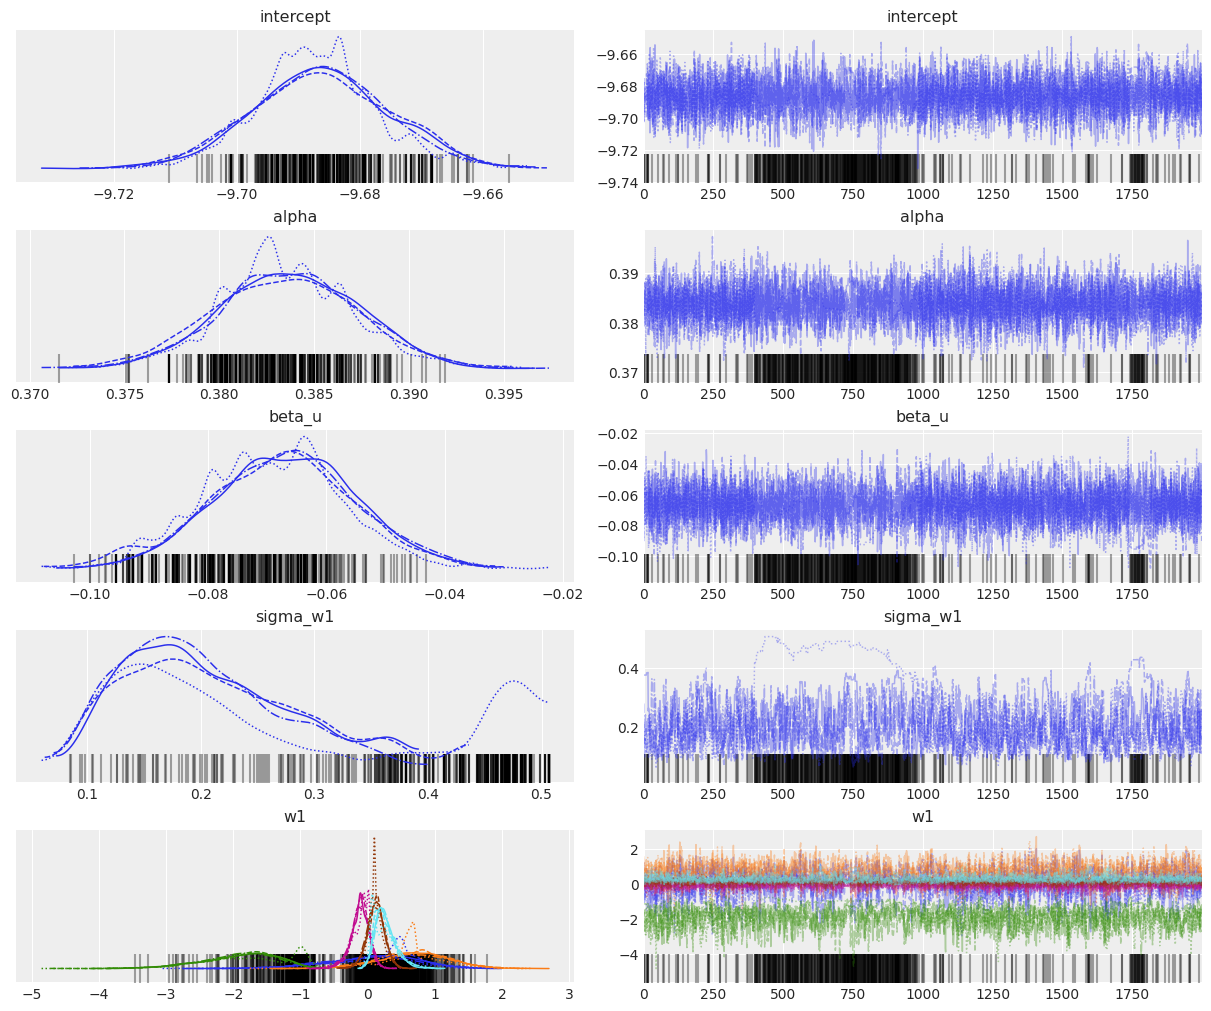

In [69]:
# 0.01
var_names = ['intercept', 'alpha', 'beta_u', 'sigma_w1', 'w1']
display(az.summary(idata2, var_names=var_names))
az.plot_trace(idata2, var_names=var_names);

function mean across samples:  1.4970236763740736e-16
-0.08417351180321656


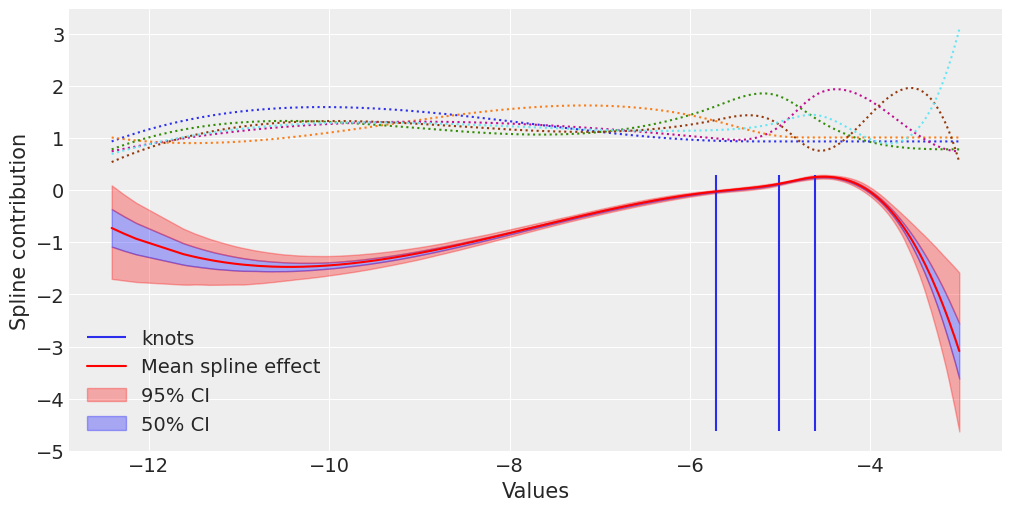

In [70]:
# 0.01
plot_spline(idata2, 'w1', 'sigma_w1', B1, data[stat_name], knots=knot_list1, show_basis=True, basis_scale=8)

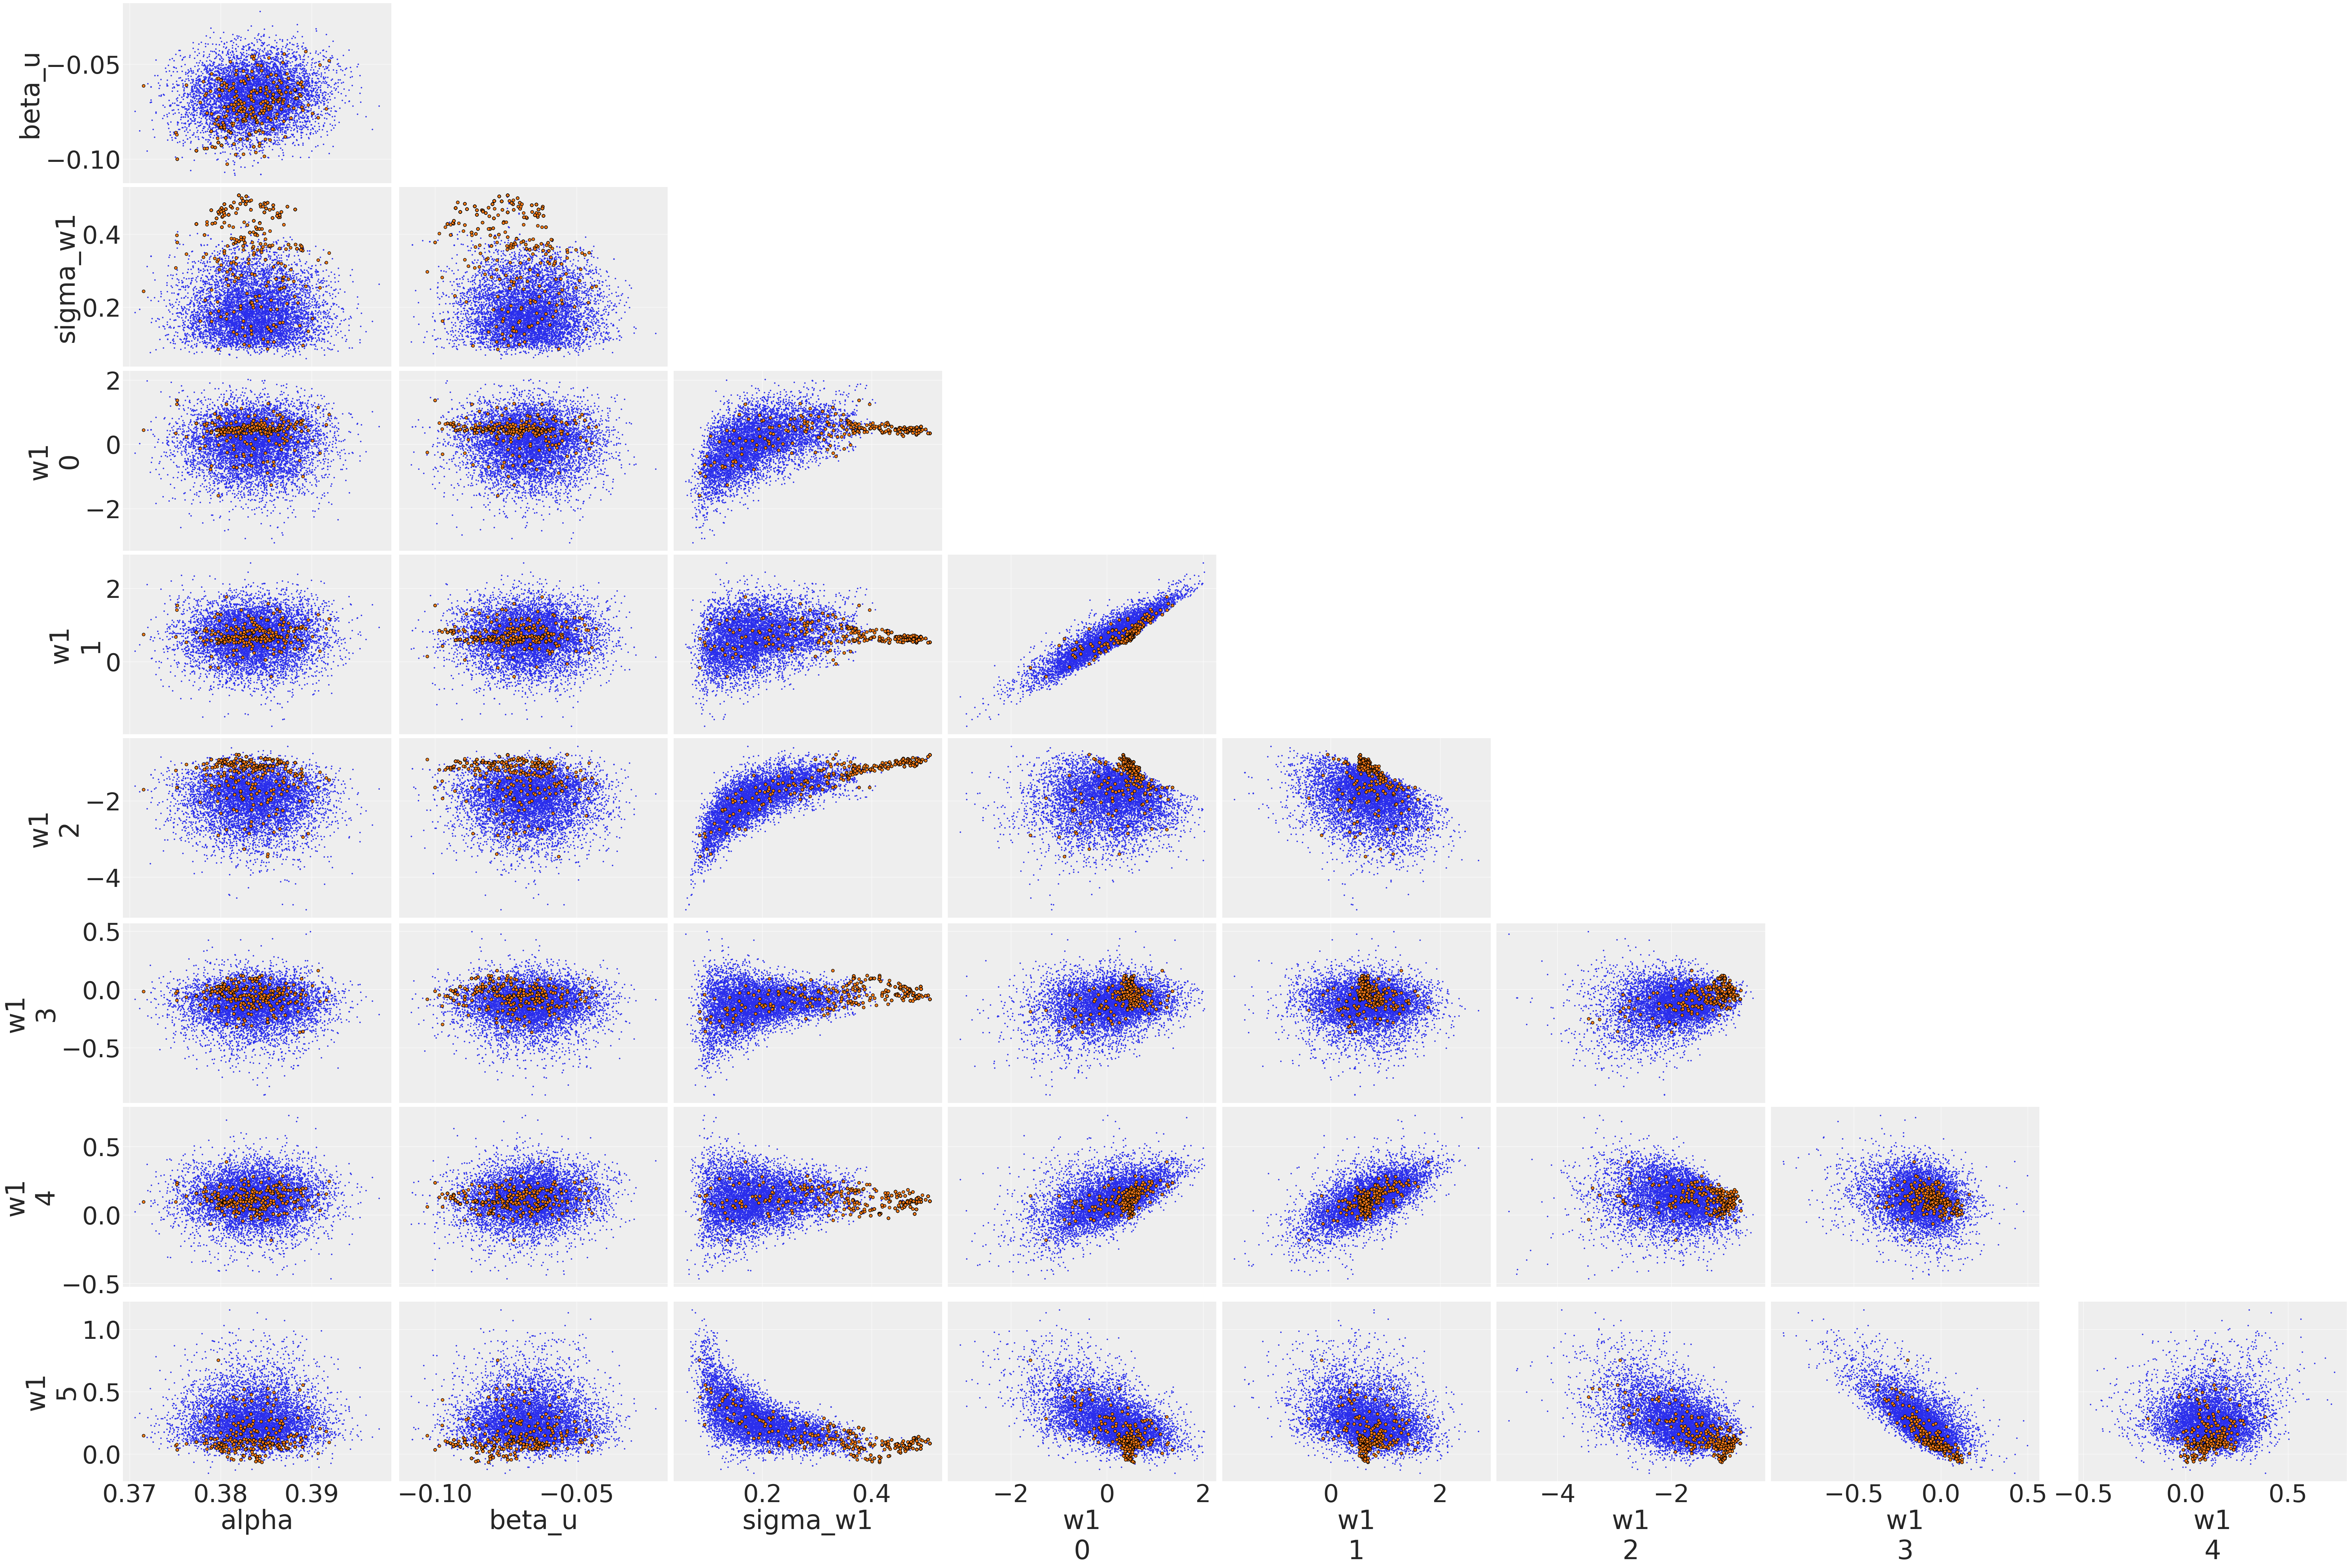

In [71]:
# 0.01
az.plot_pair(idata2, var_names=['alpha', 'beta_u', 'sigma_w1', 'w1'], textsize=50, divergences=True);

---

In [11]:
stat_name = 'tp_24hmean_pop_weighted_log1p (0)'

In [12]:
model_intercept_nb_sus1 = pm.Model()
with model_intercept_nb_sus1:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline
    # degree=3 gives cubic splines
    num_knots1 = 3
    d = data[stat_name]
    knot_list1 = np.linspace(np.min(d), np.max(d), num_knots1+2)[1:-1]
    knot_list1 = np.percentile(d, np.linspace(0, 100, num_knots1 + 2))[1:-1]
    B1 = dmatrix(
    "bs(s1, knots=knots, degree=3, include_intercept=False)-1",
    {"s1": d, "knots": knot_list1},)
    
    # Spline coefficients
    sigma_w1 = pm.HalfNormal("sigma_w1", sigma=0.5)
    w1 = pm.Normal("w1", mu=0, sigma=1, size=B1.shape[1], dims="splines")
    
    # Spline contribution (with scaled mean to zero soft constraint)
    f_s1_raw = pm.math.dot(B1, w1)
    f_s1_mean = pm.math.mean(f_s1_raw)
    f_s1_var  = pm.math.mean((f_s1_raw - f_s1_mean) ** 2)
    f_s1_std = pm.math.sqrt(f_s1_var + 1e-6)
    pm.Potential(
    "f_s1_centred_prior",
    pm.logp(pm.Normal.dist(mu=0.0, sigma=0.01), f_s1_mean/(f_s1_std+1e-6)))
    f_s1 = sigma_w1*f_s1_raw

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted_std'] +
              f_s1)

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [13]:
with model_intercept_nb_sus1:
    s = time.time()
    idata3 = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    print(f'Posterior Sampling {time.time() - s:.2f} seconds')

Posterior Sampling 152.29 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -9.666  0.011  -9.687   -9.645      0.000    0.000    7151.0   
alpha      0.378  0.004   0.371    0.385      0.000    0.000    5771.0   
beta_u    -0.089  0.012  -0.111   -0.068      0.000    0.000    3257.0   
sigma_w1   1.076  0.247   0.627    1.546      0.015    0.014     351.0   
w1[0]     -0.761  0.186  -1.094   -0.431      0.008    0.005     380.0   
w1[1]      0.098  0.062  -0.018    0.215      0.001    0.001    2272.0   
w1[2]      0.087  0.043   0.016    0.169      0.001    0.001    1126.0   
w1[3]      0.572  0.167   0.280    0.899      0.005    0.003    1112.0   
w1[4]     -2.211  0.598  -3.358   -1.150      0.023    0.010     632.0   
w1[5]     -1.696  0.855  -3.360   -0.150      0.012    0.010    4675.0   

           ess_tail  r_hat  
intercept    5171.0   1.00  
alpha        3664.0   1.00  
beta_u       3109.0   1.00  
sigma_w1      182.0   1.01  
w1[0]         177.0   1.01  
w1[1]        2829.0   1.00  
w1[2]        2230.0   1.00  
w1[3]        2249.0   1.01  
w1[4]         612.0   1.01  
w1[5]        4123.0   1.00

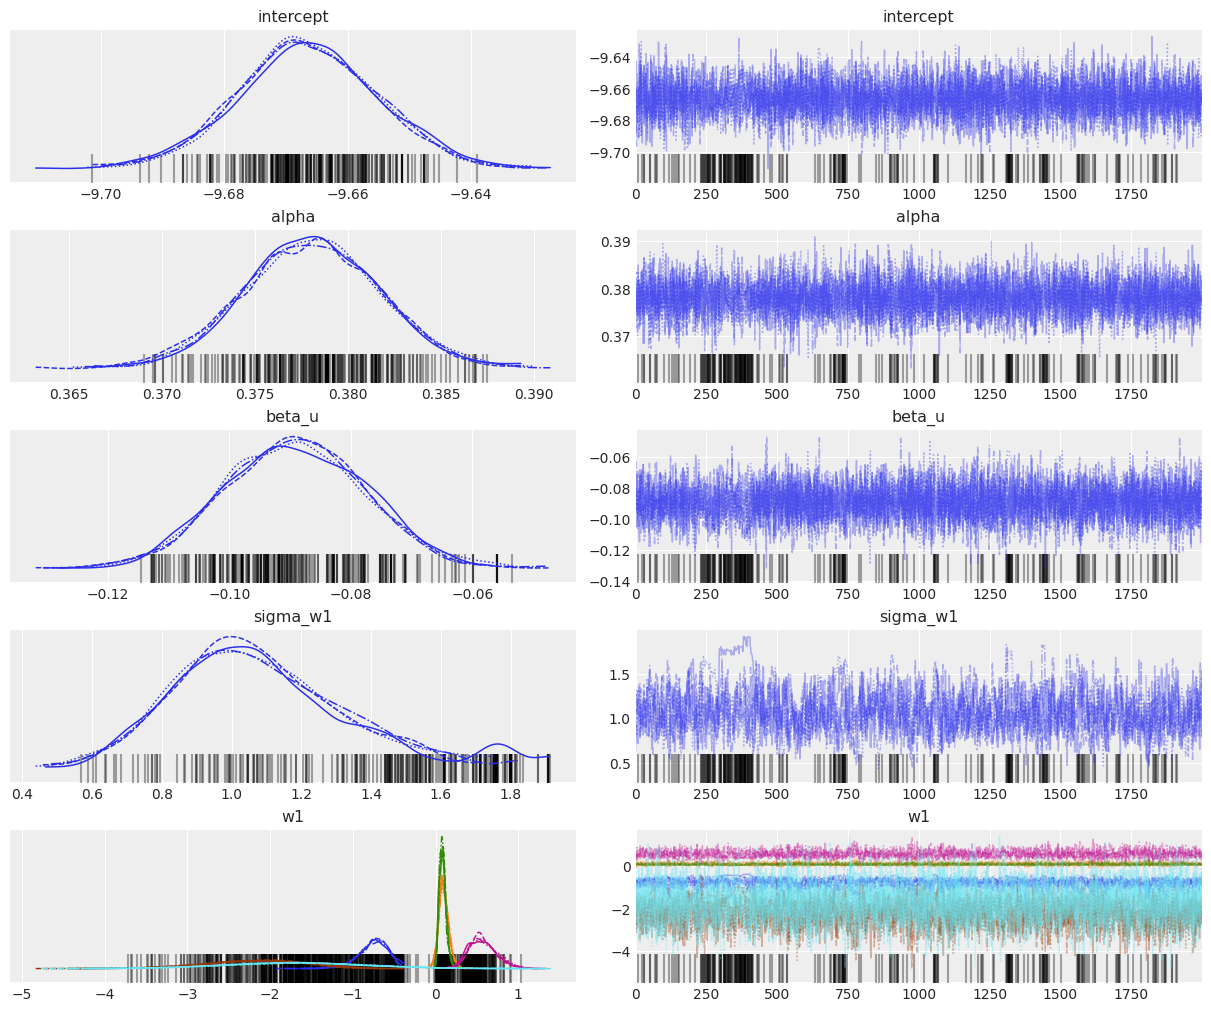

In [14]:
# 0.01
var_names = ['intercept', 'alpha', 'beta_u', 'sigma_w1', 'w1']
display(az.summary(idata3, var_names=var_names))
az.plot_trace(idata3, var_names=var_names);

function mean across samples:  0.001016559238869497
(1000, 6)


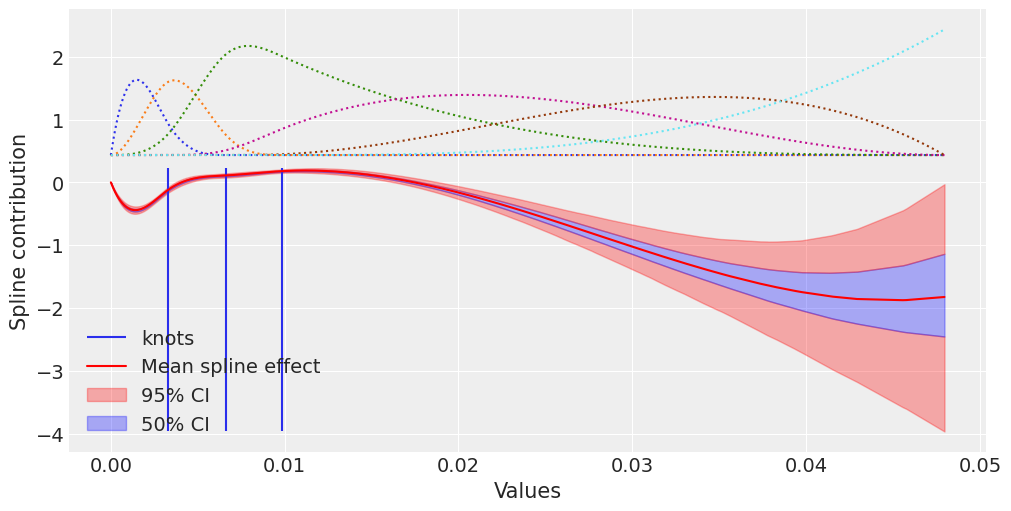

In [15]:
# 0.01
plot_spline(idata3, 'w1', 'sigma_w1', B1, data[stat_name], knots=knot_list1, show_basis=True)

---

In [22]:
stat_name = 'tp_24hmean_pop_weighted (0)'

In [23]:
model_intercept_nb_sus1 = pm.Model()
with model_intercept_nb_sus1:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline
    # degree=3 gives cubic splines
    num_knots1 = 3
    d = data[stat_name]
    knot_list1 = np.linspace(np.min(d), np.max(d), num_knots1+2)[1:-1]
    knot_list1 = np.percentile(d, np.linspace(0, 100, num_knots1 + 2))[1:-1]
    B1 = dmatrix(
    "bs(s1, knots=knots, degree=3, include_intercept=False)-1",
    {"s1": d, "knots": knot_list1},)
    
    # Spline coefficients
    sigma_w1 = pm.HalfNormal("sigma_w1", sigma=0.5)
    w1 = pm.Normal("w1", mu=0, sigma=1, size=B1.shape[1], dims="splines")
    
    # Spline contribution (with scaled mean to zero soft constraint)
    f_s1_raw = pm.math.dot(B1, w1)
    f_s1_mean = pm.math.mean(f_s1_raw)
    f_s1_var  = pm.math.mean((f_s1_raw - f_s1_mean) ** 2)
    f_s1_std = pm.math.sqrt(f_s1_var + 1e-6)
    pm.Potential(
    "f_s1_centred_prior",
    pm.logp(pm.Normal.dist(mu=0.0, sigma=0.01), f_s1_mean/(f_s1_std+1e-6)))
    f_s1 = sigma_w1*f_s1_raw

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted_std'] +
              f_s1)

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [24]:
with model_intercept_nb_sus1:
    s = time.time()
    idata1 = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    print(f'Posterior Sampling {time.time() - s:.2f} seconds')

Posterior Sampling 143.03 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -9.667  0.012  -9.689   -9.646      0.000    0.000    7193.0   
alpha      0.378  0.004   0.371    0.385      0.000    0.000    7790.0   
beta_u    -0.089  0.012  -0.111   -0.067      0.000    0.000    8768.0   
sigma_w1   1.065  0.228   0.648    1.493      0.008    0.005     925.0   
w1[0]     -0.764  0.180  -1.093   -0.465      0.005    0.004     947.0   
w1[1]      0.097  0.061  -0.014    0.212      0.001    0.001    2614.0   
w1[2]      0.090  0.043   0.016    0.172      0.001    0.001    1551.0   
w1[3]      0.570  0.166   0.287    0.896      0.004    0.003    1601.0   
w1[4]     -2.270  0.596  -3.391   -1.212      0.015    0.009    1492.0   
w1[5]     -1.679  0.848  -3.297   -0.109      0.011    0.010    6492.0   

           ess_tail  r_hat  
intercept    4833.0    1.0  
alpha        5621.0    1.0  
beta_u       5571.0    1.0  
sigma_w1      863.0    1.0  
w1[0]         865.0    1.0  
w1[1]        3537.0    1.0  
w1[2]        2044.0    1.0  
w1[3]        2638.0    1.0  
w1[4]        1689.0    1.0  
w1[5]        5169.0    1.0

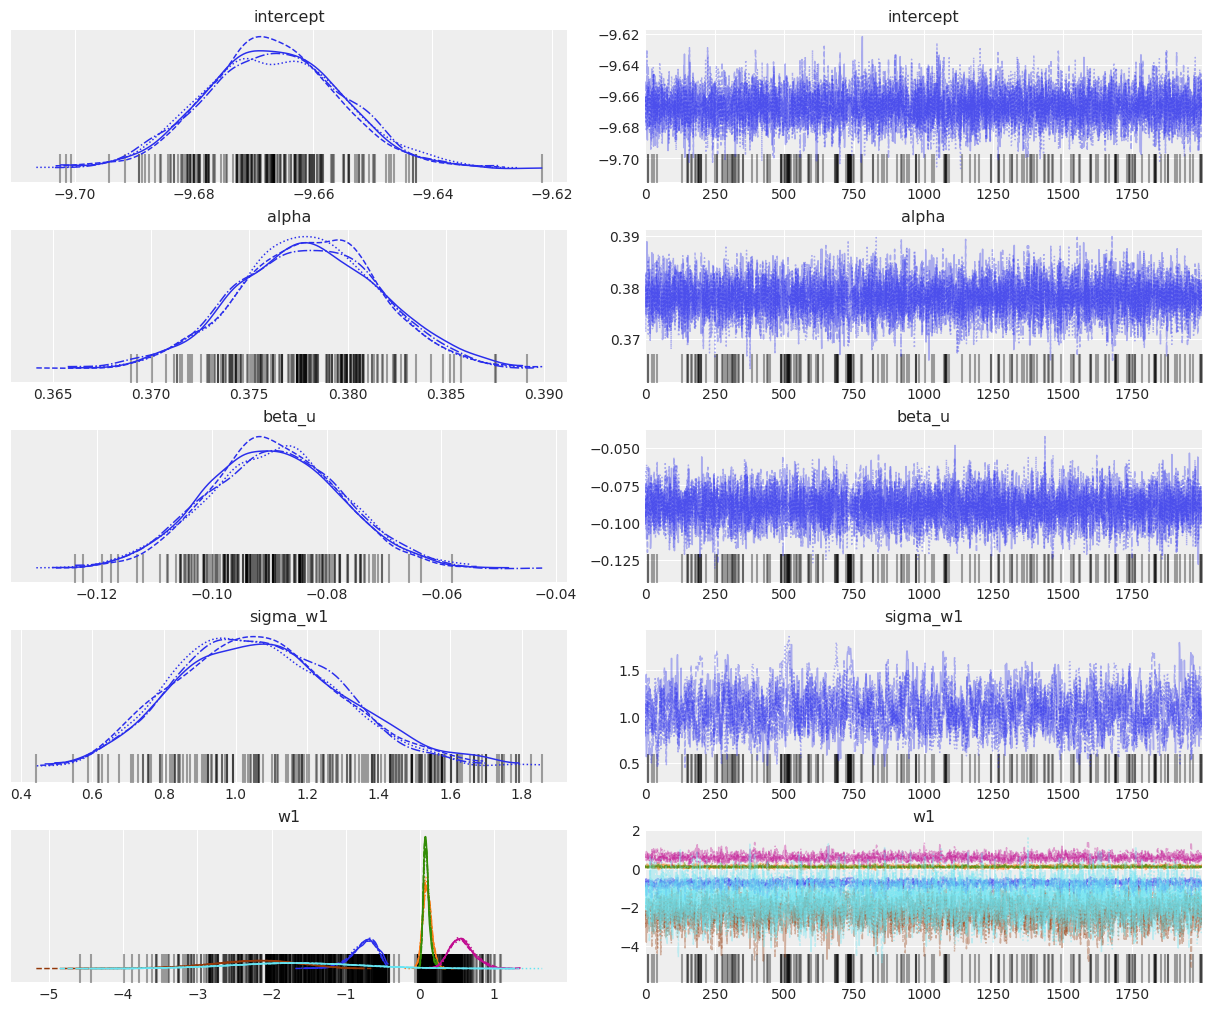

In [25]:
# 0.01
var_names = ['intercept', 'alpha', 'beta_u', 'sigma_w1', 'w1']
display(az.summary(idata1, var_names=var_names))
az.plot_trace(idata1, var_names=var_names);

function mean across samples:  0.0010575749211539868
(1000, 6)


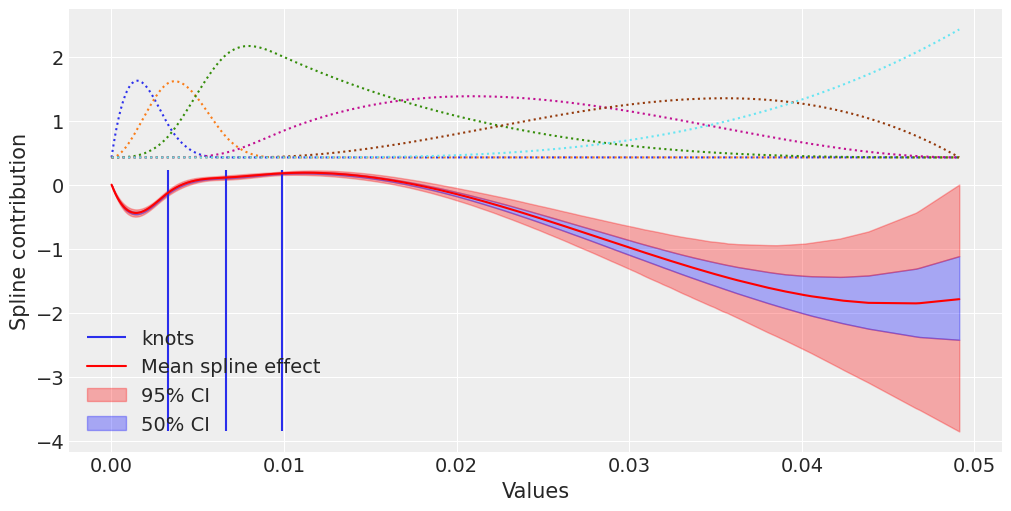

In [26]:
# 0.01
plot_spline(idata1, 'w1', 'sigma_w1', B1, data[stat_name], knots=knot_list1, show_basis=True)

/Users/lucaratzinger/.pyenv/versions/p-phylo-venv/lib/python3.14/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


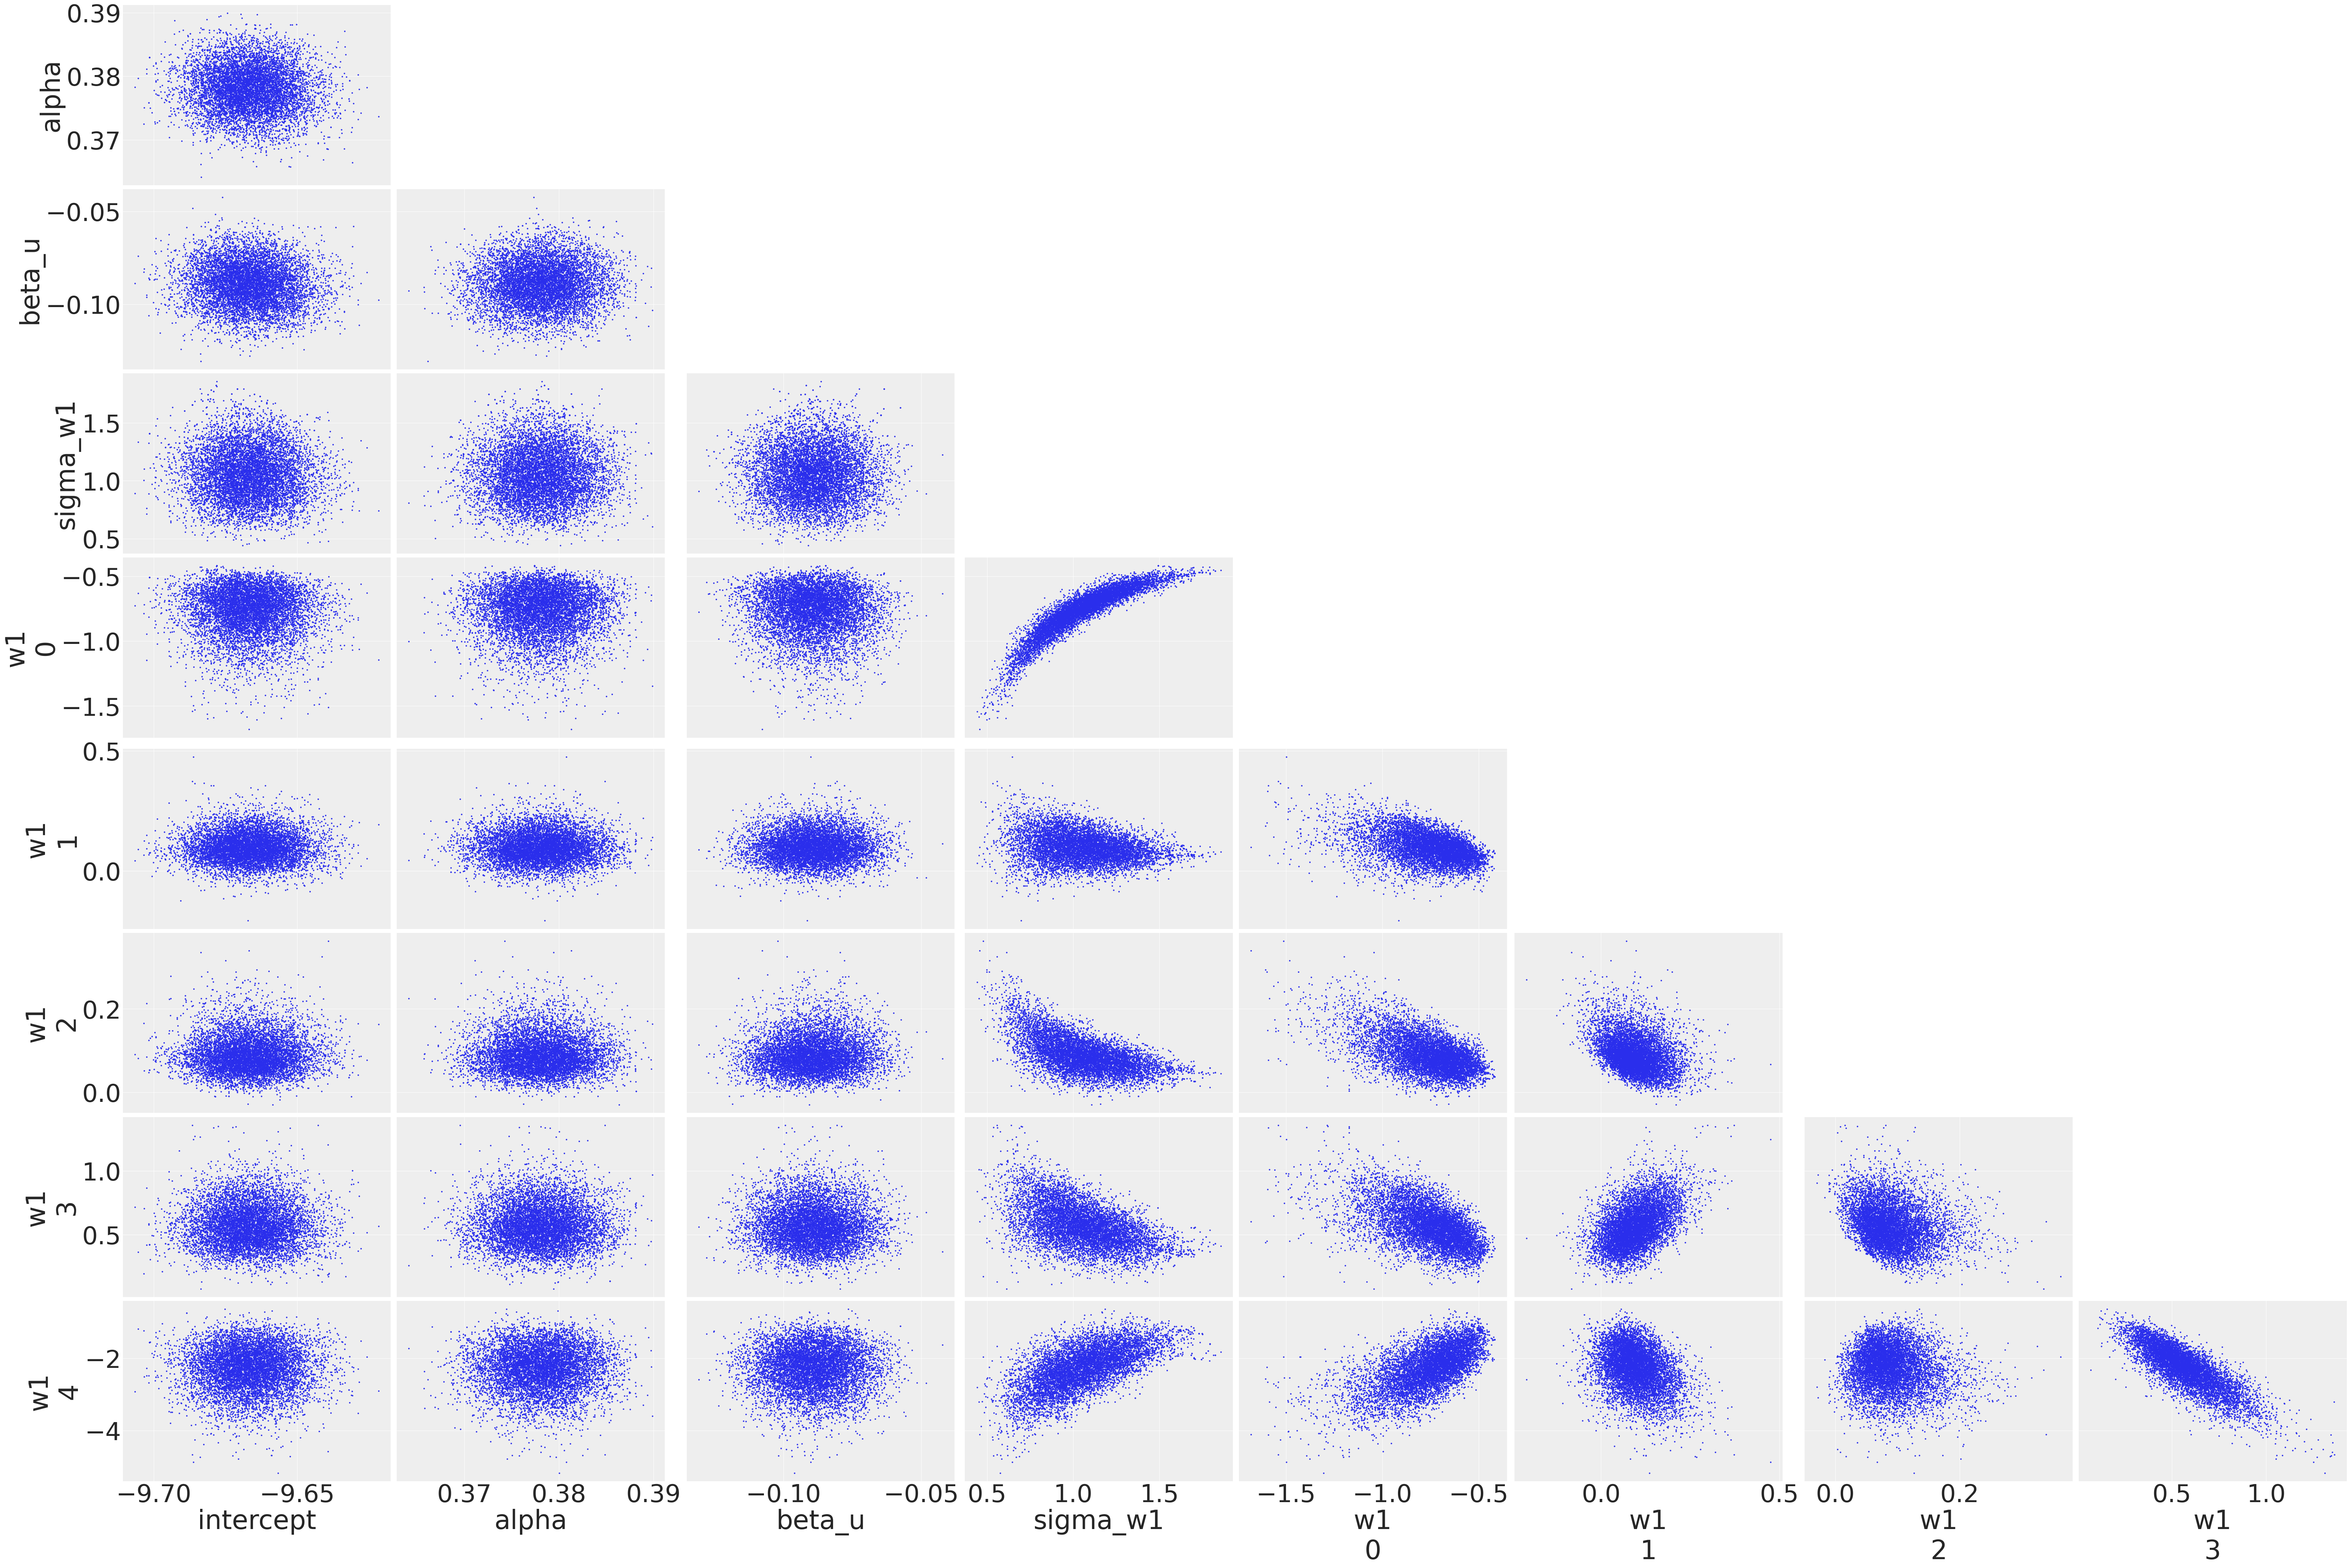

In [27]:
# 0.01
az.plot_pair(idata1, var_names=['intercept', 'alpha', 'beta_u', 'sigma_w1', 'w1'], textsize=50);